In [ ]:
# https://www.kernel-operations.io/geomloss/_auto_examples/optimal_transport/plot_optimal_transport_color.html

In [1]:
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
from geomloss import SamplesLoss

In [2]:
def load_image(filename):
    img = imageio.imread(filename)
    return img / 255.0


def RGB_cloud(filename, sampling, dtype=torch.FloatTensor):
    A = load_image(filename)
    A = A[::sampling, ::sampling, :]
    return torch.from_numpy(A).type(dtype).view(-1, 3)


def display_image(ax, x):
    W = int(np.sqrt(len(x)))
    x_ = x.view(W, W, 3).detach().cpu().numpy()
    ax.imshow(x_)


def display_cloud(ax, x):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=25 * 500 / len(x_), c=x_)

/var/folders/ft/050hs20n0lv0ths94gk906gc0000gn/T/ipykernel_76917/460778479.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename)


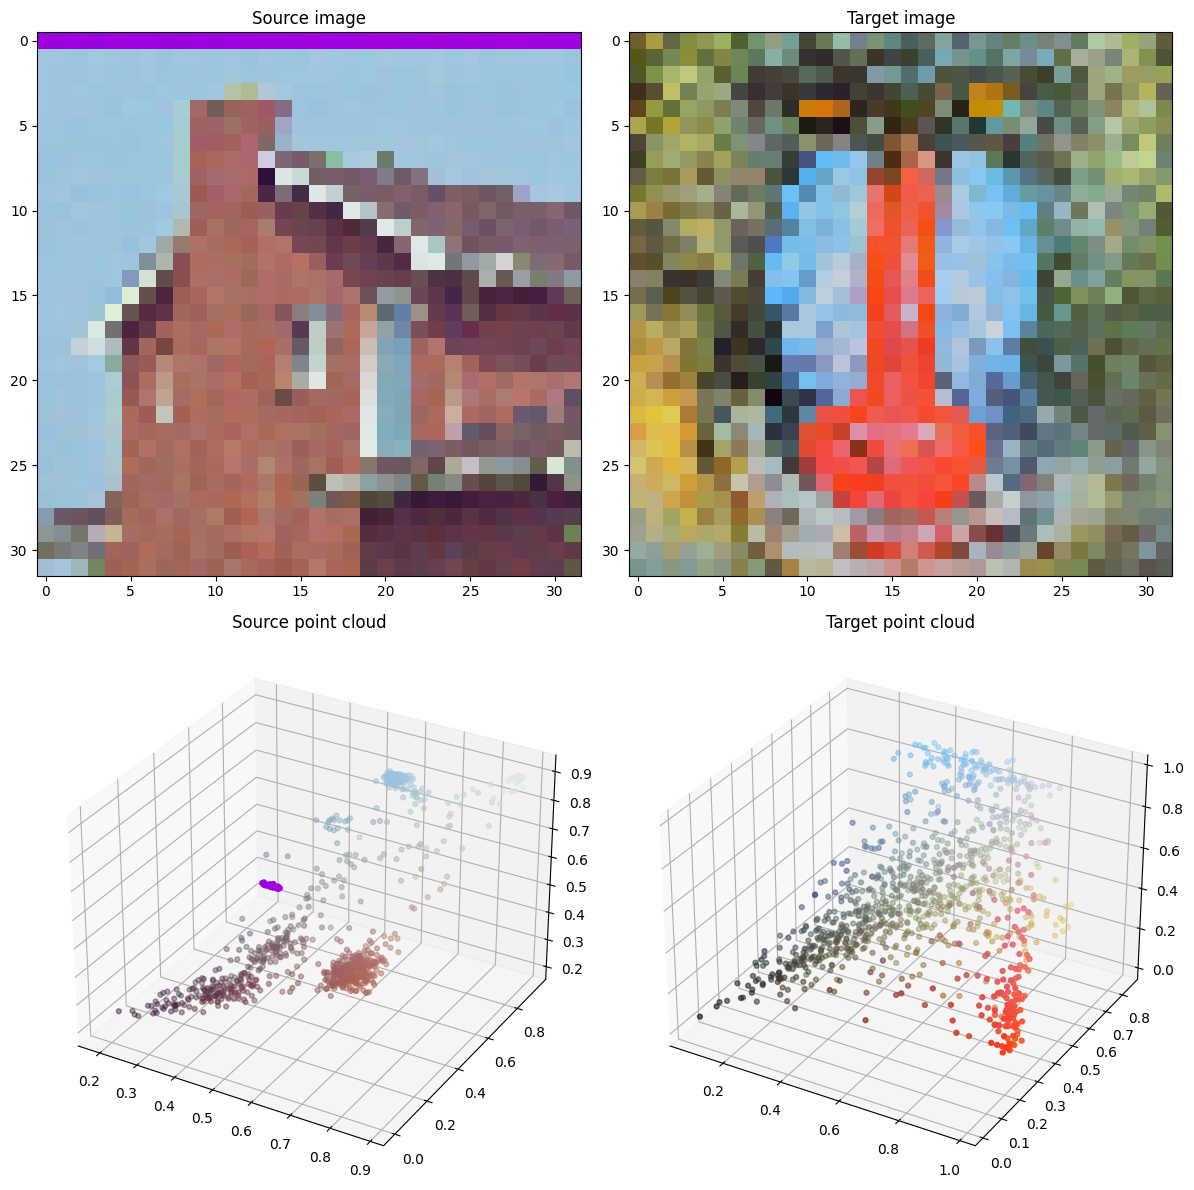

In [13]:
use_cuda = torch.cuda.is_available()
sampling = 8 if not use_cuda else 1
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

X_i = RGB_cloud("../data/house_256.png", sampling, dtype)  # (w*h, 3)
Y_j = RGB_cloud("../data/mandrill_256.png", sampling, dtype)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(2, 2, 1)
display_image(ax, X_i)
ax.set_title("Source image")
ax = fig.add_subplot(2, 2, 2)
display_image(ax, Y_j)
ax.set_title("Target image")

ax = fig.add_subplot(2, 2, 3, projection="3d")
display_cloud(ax, X_i)
ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection="3d")
display_cloud(ax, Y_j)
ax.set_title("Target point cloud")
plt.tight_layout()

In [1]:
# https://www.slideshare.net/joisino/ss-251328369

In [14]:
def color_transfer(loss, lr=1):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    num_steps = 11
    display_its = [1, 10]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()

    plt.figure(figsize=(12, 12))
    k = 3
    ax = plt.subplot(2, 2, 1)
    display_image(ax, X_i)
    ax.set_title("Source image")
    plt.xticks([], [])
    plt.yticks([], [])
    ax = plt.subplot(2, 2, 2)
    display_image(ax, Y_j)
    ax.set_title("Target image")
    plt.xticks([], [])
    plt.yticks([], [])

    for i in range(num_steps):  # Euler scheme ===============
        # Compute cost and gradient
        L_alpha_beta = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_alpha_beta, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            display_image(ax, x_i)
            ax.set_title("it = {}".format(i))
            k = k + 1
            plt.xticks([], [])
            plt.yticks([], [])

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g

    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / num_steps)
    )
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


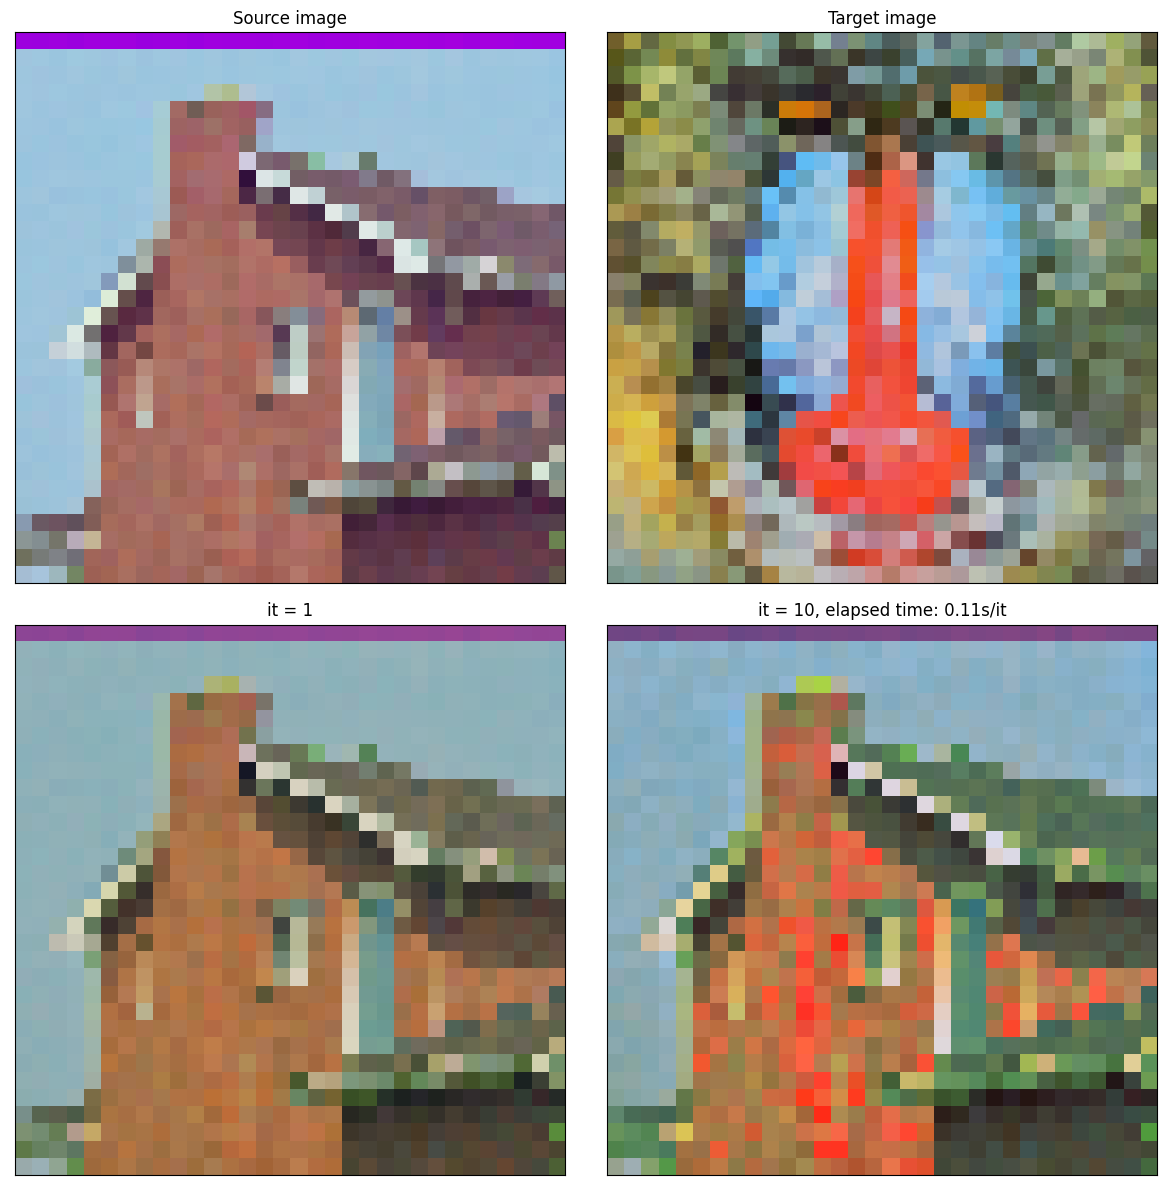

In [15]:
color_transfer(SamplesLoss("sinkhorn", blur=0.3))

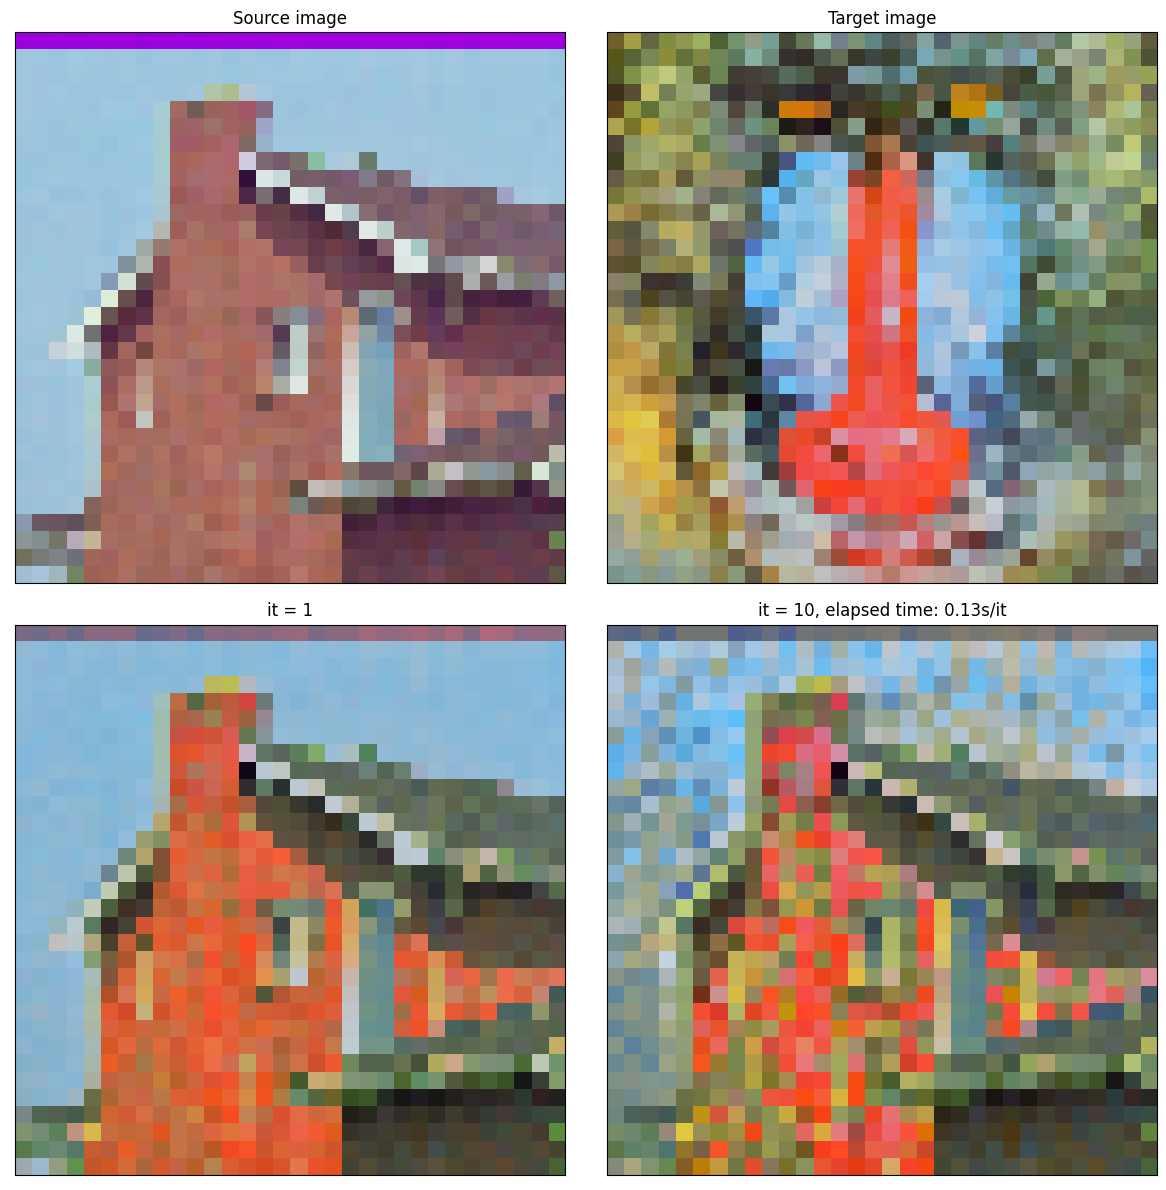

In [16]:
color_transfer(SamplesLoss("sinkhorn", blur=0.1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


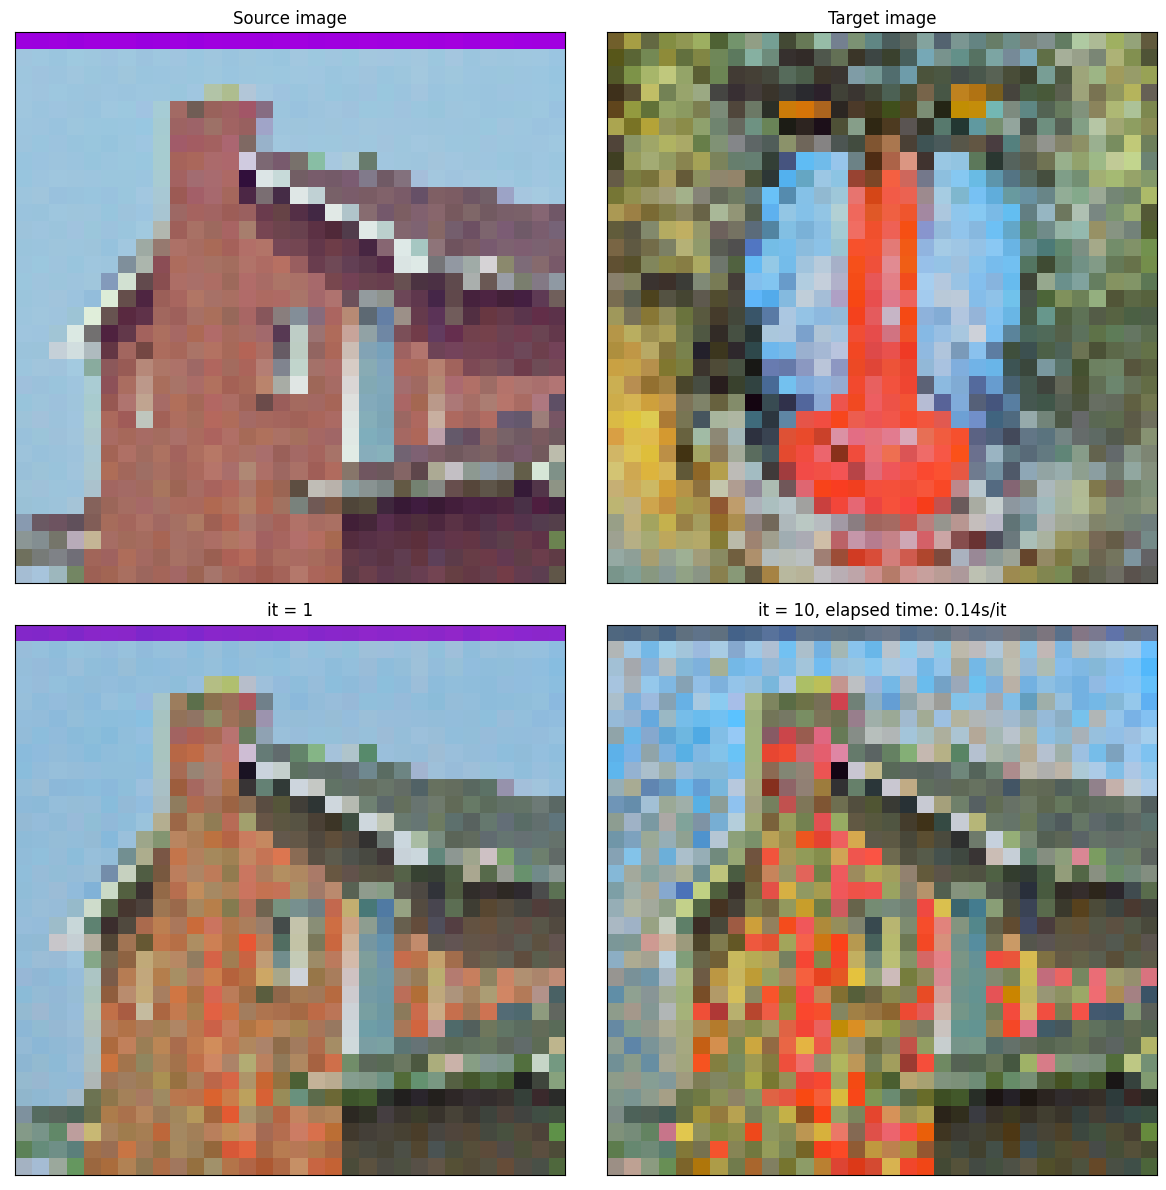

In [17]:
color_transfer(SamplesLoss("sinkhorn", blur=0.1, reach=0.4))
plt.show()